# Signal Filter Design for JETI

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import minimize
from scipy.optimize import Bounds

import JETI_Log_Parser as JLP

In [2]:
def double_exponential_filter(signal,
                              old_signal_1,
                              old_signal_2,
                              old_climb_rate,
                              tau_1, tau_2, dyn_alpha_divisor,
                              delta_t):

        alfa_1 = delta_t / (tau_1 + delta_t)
        alfa_2 = delta_t / (tau_2 + delta_t)

        smoothed_signal_1 = old_signal_1 - alfa_1 * (old_signal_1 - signal)
        smoothed_signal_2 = old_signal_2 - alfa_2 * (old_signal_2 - signal)

        # calc default gain from time constants chosen
        factor = 1 / (tau_2 - tau_1 + 1.e-9)

        climb_rate = (smoothed_signal_1 - smoothed_signal_2) * factor

        dyn_alpha = abs((old_climb_rate - climb_rate) / dyn_alpha_divisor)
        dyn_alpha = min(dyn_alpha, 1.0)
        smoothed_climb_rate = old_climb_rate - dyn_alpha * (old_climb_rate - climb_rate)

        return smoothed_signal_1, smoothed_signal_2, smoothed_climb_rate


In [3]:
def target_function(params, times, noisy_signal):

    """Calculates a target function"""

    tau_1, tau_2, dyn_alpha_divisor = params
    delta_t = np.diff(times)
    # insert a value at the beginning to delta_t to keep the length of the arrays consistent
    delta_t = np.insert(delta_t, 0, delta_t[0])

    old_altitude_1 = noisy_signal[0]
    old_altitude_2 = noisy_signal[0]
    climb_rate = 0

    filtered_signal = np.zeros(len(noisy_signal))
    for i in range(len(noisy_signal)):
       dt = delta_t[i]
       old_altitude_1, old_altitude_2, climb_rate = double_exponential_filter(noisy_signal[i],
                                                                               old_altitude_1,
                                                                               old_altitude_2,
                                                                               climb_rate,
                                                                               tau_1, tau_2, dyn_alpha_divisor,
                                                                               dt)
       filtered_signal[i] = climb_rate

    climb_rate_ideal = np.array(climb_rate_ideal) # Use climb_rate_ideal

    # Calculate the lag - now altitude lag
    lag = np.sum((filtered_signal - climb_rate_ideal) ** 2) # Error between filtered and ideal climb rate

    # Calculate the derivative to find noise
    dt_time = np.diff(times)
    filtered_signal_deriv = np.diff(filtered_signal)
    noise = np.sum((filtered_signal_deriv / dt_time) ** 2) # Error between filtered climb rate derivative and ideal climb rate derivative

    # Weighted Target Function: Lag + Noise - USER CAN ADJUST NOISE_WEIGHT
    NOISE_WEIGHT = 0.009 # User-adjustable weight for noise term - Start with 0.1, adjust as needed
    target =  lag + (NOISE_WEIGHT * noise) # Weighted sum of lag and noise

    return target


In [4]:
def generate_altitude_signal(duration, dt, noise_amplitude=0, add_noise=True):
    """
    Generates an artificial altitude signal simulating two cycles of climb, plateau, and descent.
    Profile: climb 2.5m in 2.5s, stay at 2.5m for 1s, sink to 0m in 0.25s and stay at 0m für 0.75s. one cycle is 4.5s. make two cycles
    Source: https://www.rc-network.de/threads/variometer-algorithmus.736247/
    """

    times = np.arange(0, duration, dt)
    altitude_signal_ideal = [] # Ideal altitude without noise calculation
    climb_rate_signal = []
    cycle_duration = 4.5

    # Calculate the altitude based on the time
    for t in times:
        time_in_cycle = t % cycle_duration
        if time_in_cycle < 2.5:
            # climbing phase (2.5m in 2.5s)
            altitude = (2.5 / 2.5) * time_in_cycle  # 1 m/s climb rate
            climb_rate = (2.5 / 2.5)
        elif time_in_cycle < 2.5 + 1.0:
            # plateau phase at 2.5m (1s)
            altitude = 2.5
            climb_rate = 0
        elif time_in_cycle < 2.5 + 1.0 + 0.25:
            # descent phase (sink to 0m in 0.25s)
            altitude = 2.5 - (2.5 / 0.25) * (time_in_cycle - (2.5 + 1.0)) # -10 m/s sink rate
            climb_rate = -(2.5 / 0.25)
        elif time_in_cycle < 2.5 + 1.0 + 0.25 + 0.75:
            # plateau phase at 0m (0.75s)
            altitude = 0
            climb_rate = 0
        else: # this should not happen given the modulo operation, but for completeness
            altitude = 0
            climb_rate = 0

        altitude_signal_ideal.append(altitude) # Store ideal altitude
        climb_rate_signal.append(climb_rate)
        # climb_rate_signal = np.array(climb_rate_signal)

    if add_noise:
        # Add random noise to the IDEAL altitude signal
        noisy_altitude_signal = [
            altitude + random.uniform(-noise_amplitude, noise_amplitude) for altitude in altitude_signal_ideal
        ]
        return times, noisy_altitude_signal, climb_rate_signal, altitude_signal_ideal # Return noisy and ideal altitude
    else:
        return times, altitude_signal_ideal, climb_rate_signal, altitude_signal_ideal # Return ideal altitude (and also ideal as 'noisy' to keep function signature consistent)


In [5]:
# read example log data from a file
filename = 'JETI_sample.log'

with open(filename, "r", encoding='utf-8', errors='replace') as file:
    telemetry_log_data = file.read()

# Create a parser instance and parse the log data
parser = JLP.JetiTelemetryParser(telemetry_log_data)
parser.parse()

devices = parser.get_devices()

# print devices and channels
for device_name, device_data in devices.items():
    print(f"Device: {device_name}")
    for channel_id, channel_data in device_data["channels"].items():
        print(f"  Channel {channel_id}: {channel_data['name']} ({channel_data['unit']})")


Device: Tx
Device: REX7A
  Channel 1: U Rx (V)
  Channel 2: A1 ()
  Channel 3: A2 ()
  Channel 4: Q (%)
  Channel 14: Temperatur (°C)
  Channel 15: Roll (°)
  Channel 16: Nick (°)
  Channel 17: Heck (°)
  Channel 18: G-Kraft (G)
  Channel 19: Status ()
Device: MHB
  Channel 2: Hoehe (m)
  Channel 3: Max. altitude (m)
  Channel 4: Vario (m/s)
  Channel 5: Max. climb (m/s)
  Channel 6: Druck (mbar)
  Channel 7: Temperature (C)
  Channel 15: Raw Pressure (Pa)


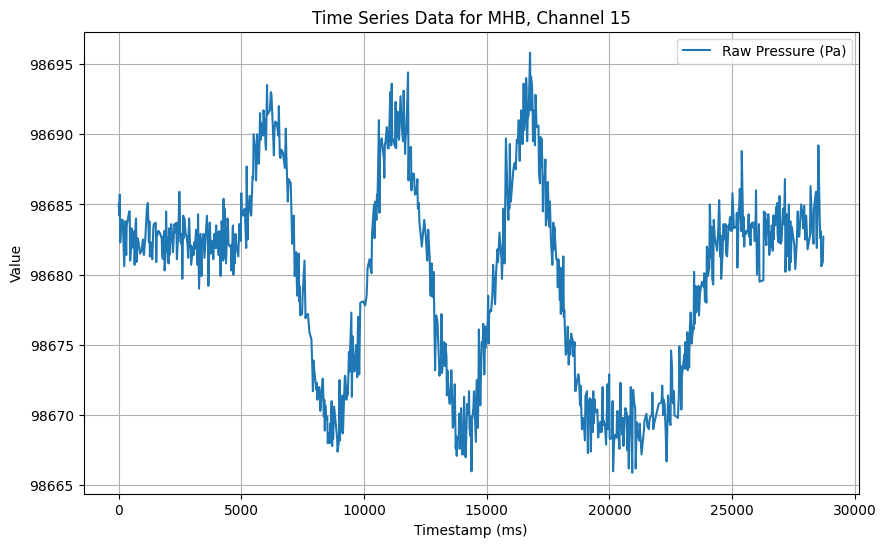

In [6]:
# Specify the device and channel you want to plot
target_device = "MHB"
target_channel_id = 15

# Retrieve the channel's data
if target_device in devices and target_channel_id in devices[target_device]["data"]:
    data = devices[target_device]["data"][target_channel_id]

timestamps = data[:, 0]
values = data[:, 1]

# combine timestamps and values into a numpy array
signal = np.column_stack((timestamps, values))

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(timestamps, values, label=f"{devices[target_device]['channels'][target_channel_id]['name']} ({devices[target_device]['channels'][target_channel_id]['unit']})")
plt.title(f"Time Series Data for {target_device}, Channel {target_channel_id}")
plt.xlabel("Timestamp (ms)")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()

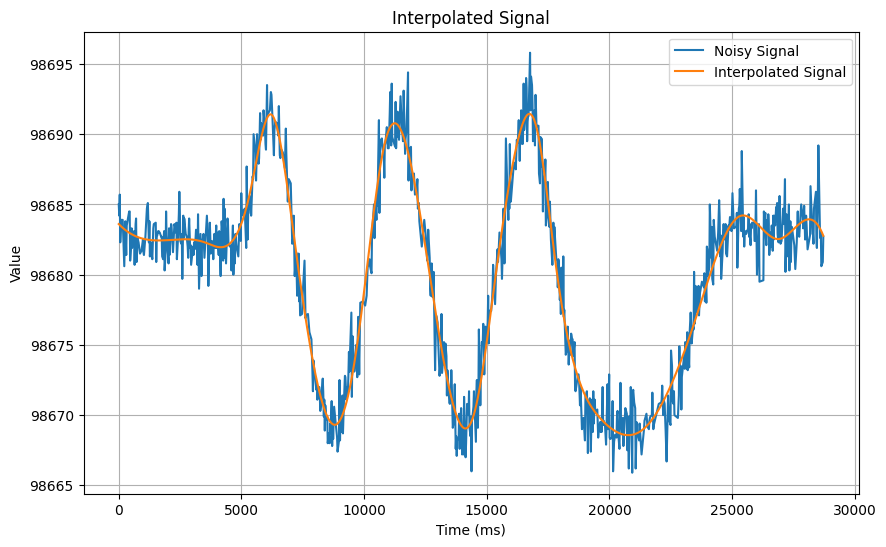

In [19]:
# the data stored in signal are the noisy data. make an interploation to get a smooth curve
# the signal represents raw sensor data (pressure) and the time in milliseconds
times = signal[:, 0]
noisy_signal = signal[:, 1]

# suggest a scipy based smoothing/interpolation method (RBF, spline, etc.) to get a smooth curve
from scipy.interpolate import UnivariateSpline

# create an interpolation function with smoothing factor
smoothing_factor = 2000  # You can adjust this parameter to control the smoothness
interpolated_signal = UnivariateSpline(times, noisy_signal, s=smoothing_factor)

# create a new time vector for the interpolated signal
new_times = np.linspace(times[0], times[-1], 1000)

# calculate the interpolated signal
interpolated_values = interpolated_signal(new_times)

# plot the noisy signal and the interpolated signal
plt.figure(figsize=(10, 6))
plt.plot(times, noisy_signal, label="Noisy Signal")
plt.plot(new_times, interpolated_values, label="Interpolated Signal")
plt.title("Interpolated Signal")
plt.xlabel("Time (ms)")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()
